# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=70% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='notebook_ims/style_tx_cat.png' width=70% />

In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:12<00:00, 47115072.74it/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Load in Content and Style Images

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
content = load_image('images/kotn.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/iblard_jikan.jpg', shape=content.shape[-2:]).to(device)

In [7]:
# helper function for un-normalizing an image and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

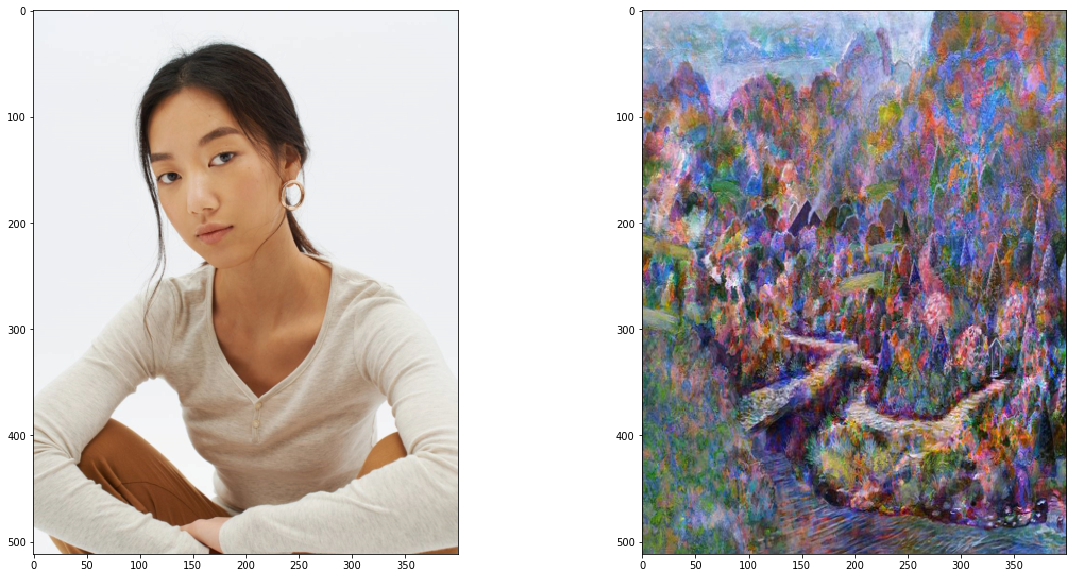

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [8]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Content and Style Features


In [19]:
def load_image(img_path, max_size = 400, shape = None):
    # load  & transform an image to be <= 400 px in width & height (large img: slow to process)
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
        
    transform = transforms.Compose([transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])
    # discard transparent, alpha channel && add batch dimension:
    image = transform(image)[:3, :, :].unsqueeze(0)
    
    return image

def get_features(image, model, layers = None):
    # mapping layer names of PyTorch's VGGNet to names from the paper
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for idx, layer in model._modules.items():
        x = layer(x)  # Applying vgg's frozen weights to the image pixel values
        if idx in layers:
            features[layers[idx]] = x
            
    return features

# Dict w/ 6 elements: keys- conv#_#// values- weights of that layer
content_features = get_features(content, vgg)  
style_features = get_features(style, vgg)

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

In [12]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
      
    return gram 

style_gram_matrices = {layer: gram_matrix(style_features[layer]) for layer in style_features}

## Create Target Image 

We can now create a third "target" image and prep it for change. It is a good idea to start of with the target as a copy of our *content* image, then iteratively change its style

In [26]:
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. If you weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_alpha`) and a beta (`style_beta`). This ratio will affect how _stylized_ your final image is. 

In [14]:
# weighting earlier layers more will result in *larger* style artifacts
style_weights = {'conv1_1': 1., 
                 'conv2_1': 0.75,
                 'conv3_1': 0.2, 
                 'conv4_1': 0.2, 
                 'conv5_1': 0.2}

content_alpha = 1
style_beta = 1e6

## Updating the Target & Calculating Losses

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> You'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, you'll see that this value is normalized by the size of the layer.

#### Total Loss

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!


Total loss:  32759918.0


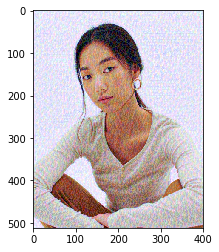

Total loss:  19318046.0


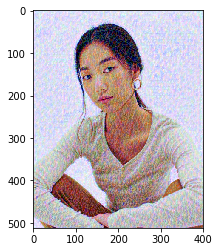

Total loss:  12049958.0


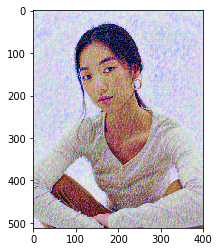

Total loss:  7607682.5


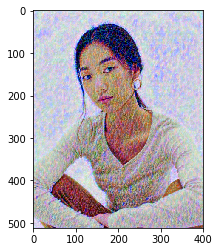

Total loss:  4963895.5


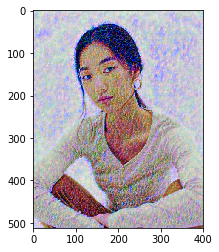

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam([target_image], lr = 0.003)
print_every = 400
n_epochs = 2000


for epoch in range(n_epochs):
    target_features = get_features(target_image, vgg)
    
    content_loss = criterion(target_features['conv4_2'], content_features['conv4_2']) 
    
    style_loss = 0
    for layer in style_loss_weights:                                          
        style_loss += style_loss_weights[layer] * criterion(gram_matrix(target_features[layer]), style_gram_matrices[layer])
        _, d, h, w = target_features[layer].size()
        style_loss = style_loss / (d*h*w)
    
    total_loss = content_alpha * content_loss + style_beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()     # Target image gets updated here
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

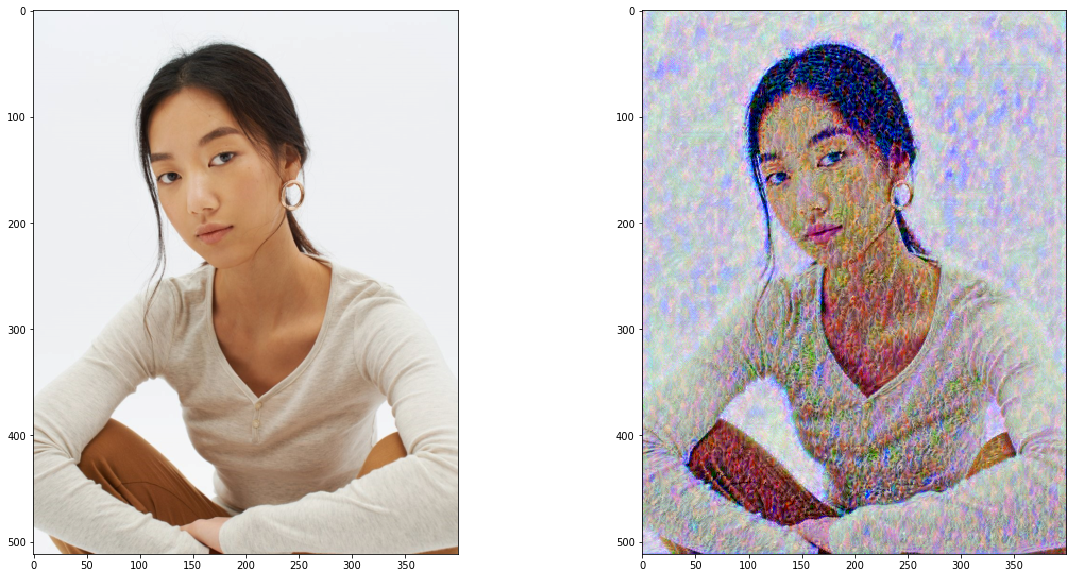

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))